In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Paths
source_dir = "raw_data/plantvillage dataset/color"
train_dir = "data/train"
val_dir = "data/val"
test_dir = "data/test"

# Create directories
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Get all class folders
class_folders = sorted([d for d in os.listdir(source_dir) 
                       if os.path.isdir(os.path.join(source_dir, d))])

print("=" * 60)
print("ORGANIZING PLANTVILLAGE DATASET")
print("=" * 60)
print(f"Found {len(class_folders)} classes")
print(f"Source directory: {source_dir}\n")

# Track distribution
class_distribution = defaultdict(lambda: {'train': 0, 'val': 0, 'test': 0})
total_train = 0
total_val = 0
total_test = 0

for class_name in class_folders:
    class_path = os.path.join(source_dir, class_name)
    
    # Get all images in this class
    images = [f for f in os.listdir(class_path) 
              if f.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'))]
    
    if len(images) == 0:
        print(f"⚠️  Warning: {class_name} has no images, skipping...")
        continue
    
    # Handle small classes: ensure at least 1 image in val and test
    if len(images) < 7:
        # For very small classes, use: 1 val, 1 test, rest train
        if len(images) >= 3:
            train_imgs = images[:-2]
            val_imgs = [images[-2]]
            test_imgs = [images[-1]]
        elif len(images) == 2:
            train_imgs = [images[0]]
            val_imgs = [images[1]]
            test_imgs = []
        else:  # len(images) == 1
            train_imgs = images
            val_imgs = []
            test_imgs = []
    else:
        # Normal split: 70% train, 15% val, 15% test
        train_imgs, temp_imgs = train_test_split(
            images, test_size=0.3, random_state=42
        )
        val_imgs, test_imgs = train_test_split(
            temp_imgs, test_size=0.5, random_state=42
        )
    
    # Create class folders in split directories
    for split_dir, split_imgs in [(train_dir, train_imgs), 
                                   (val_dir, val_imgs), 
                                   (test_dir, test_imgs)]:
        class_split_dir = os.path.join(split_dir, class_name)
        os.makedirs(class_split_dir, exist_ok=True)
        
        # Copy images
        for img in split_imgs:
            src = os.path.join(class_path, img)
            dst = os.path.join(class_split_dir, img)
            shutil.copy2(src, dst)
    
    # Track distribution
    class_distribution[class_name] = {
        'train': len(train_imgs),
        'val': len(val_imgs),
        'test': len(test_imgs),
        'total': len(images)
    }
    
    total_train += len(train_imgs)
    total_val += len(val_imgs)
    total_test += len(test_imgs)
    
    print(f"{class_name:40s}: {len(train_imgs):4d} train, {len(val_imgs):4d} val, {len(test_imgs):4d} test (total: {len(images)})")

print("\n" + "=" * 60)
print("DATA ORGANIZATION COMPLETE")
print("=" * 60)
print(f"Total images:")
print(f"  Train: {total_train:,} ({total_train/(total_train+total_val+total_test)*100:.1f}%)")
print(f"  Val:   {total_val:,} ({total_val/(total_train+total_val+total_test)*100:.1f}%)")
print(f"  Test:  {total_test:,} ({total_test/(total_train+total_val+total_test)*100:.1f}%)")

# Verify class distribution
print("\n" + "=" * 60)
print("CLASS DISTRIBUTION VERIFICATION")
print("=" * 60)
print(f"{'Class':<40} {'Train%':<8} {'Val%':<8} {'Test%':<8} {'Status'}")
print("-" * 70)

for class_name, dist in sorted(class_distribution.items()):
    total = dist['total']
    train_pct = (dist['train'] / total * 100) if total > 0 else 0
    val_pct = (dist['val'] / total * 100) if total > 0 else 0
    test_pct = (dist['test'] / total * 100) if total > 0 else 0
    
    # Check if distribution is roughly balanced
    status = "✅" if (65 <= train_pct <= 75 and 12 <= val_pct <= 18 and 12 <= test_pct <= 18) or total < 7 else "⚠️"
    
    print(f"{class_name:<40} {train_pct:>6.1f}% {val_pct:>6.1f}% {test_pct:>6.1f}% {status}")

print(f"\nData structure:")
print(f"  {train_dir}/")
print(f"  {val_dir}/")
print(f"  {test_dir}/")
print(f"\n✅ Ready for training!")

ORGANIZING PLANTVILLAGE DATASET
Found 38 classes
Source directory: plantvillage dataset/color

Apple___Apple_scab                      :  441 train,   94 val,   95 test (total: 630)
Apple___Black_rot                       :  434 train,   93 val,   94 test (total: 621)
Apple___Cedar_apple_rust                :  192 train,   41 val,   42 test (total: 275)
Apple___healthy                         : 1151 train,  247 val,  247 test (total: 1645)
Blueberry___healthy                     : 1051 train,  225 val,  226 test (total: 1502)
Cherry_(including_sour)___Powdery_mildew:  736 train,  158 val,  158 test (total: 1052)
Cherry_(including_sour)___healthy       :  597 train,  128 val,  129 test (total: 854)
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot:  359 train,   77 val,   77 test (total: 513)
Corn_(maize)___Common_rust_             :  834 train,  179 val,  179 test (total: 1192)
Corn_(maize)___Northern_Leaf_Blight     :  689 train,  148 val,  148 test (total: 985)
Corn_(maize)___health

In [ ]:
# import libraries 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class PlantDiseaseDataset(Dataset):
    """
    Custom Dataset class for plant disease images
    
    """
    def __init__(self, data_dir, transform=None):
        """
        Parameters:
        -----------
        data_dir : str
            Directory containing class folders (e.g., 'healthy', 'disease_spot')
        transform : torchvision.transforms
            Image transformations (augmentation, normalization)

        """
        self.data_dir = data_dir
        self.transform = transform
       
        
        # Get all image paths and labels
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = {}
        
        # Find all class folders
        classes = sorted([d for d in os.listdir(data_dir) 
                         if os.path.isdir(os.path.join(data_dir, d))])
        
        # Create class mappings
        for idx, class_name in enumerate(classes):
            self.class_to_idx[class_name] = idx
            self.idx_to_class[idx] = class_name
        
        # Collect all images
        for class_name in classes:
            class_dir = os.path.join(data_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])
        
        print(f"Loaded {len(self.image_paths)} images from {len(classes)} classes")
        print(f"Classes: {classes}")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        """
        Get one image and its label
        
        Returns:
        --------
        image : torch.Tensor
            Preprocessed image (C, H, W)
        label : int
            Class label
        """
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Ensure RGB format
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        
        return image, label

Loaded 37998 images from 38 classes
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites 

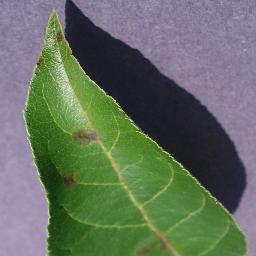

In [ ]:
data = PlantDiseaseDataset('data/train')

# Quick check to see what the data looks like
img = data[0][0]
img



In [ ]:
# Setting up image transforms for training and validation
# I'm using ImageNet normalization stats since we'll use a pre-trained model
# For training, I add augmentation to help the model generalize better

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),           # Resize to standard size
    transforms.RandomHorizontalFlip(0.5),   # Random flip (augmentation)
    transforms.RandomRotation(15),           # Random rotation (augmentation)
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Color variation
    transforms.ToTensor(),                   # Convert to tensor (0-1 range)
    transforms.Normalize(                    # Normalize to ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# No augmentation for validation/test - we want consistent evaluation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = PlantDiseaseDataset('data/train', transform=train_transform)
val_dataset = PlantDiseaseDataset('data/val', transform=val_transform)
test_dataset = PlantDiseaseDataset('data/test', transform=val_transform)

print(f"\nDataset loaded:")
print(f"  Training images: {len(train_dataset)}")
print(f"  Validation images: {len(val_dataset)}")
print(f"  Test images: {len(test_dataset)}")
print(f"  Total classes: {len(train_dataset.class_to_idx)}")

Loaded 37998 images from 38 classes
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites 

In [ ]:
# Creating balanced subsets for faster experimentation
# This is useful when you want to quickly test ideas without training on the full dataset
# The function ensures all 38 classes are represented proportionally
import random
from torch.utils.data import Subset
from collections import defaultdict

random.seed(42)
torch.manual_seed(42)

# Store original datasets for class mappings
train_dataset_full = train_dataset
val_dataset_full = val_dataset
test_dataset_full = test_dataset

TRAIN_SUBSET_SIZE = 5000
VAL_SUBSET_SIZE = 1000
TEST_SUBSET_SIZE = 1000

def create_balanced_subset(dataset, subset_size, dataset_name):
    """
    Create a balanced subset that samples from ALL classes
    
    Parameters:
    -----------
    dataset : Dataset
        Full dataset
    subset_size : int
        Target size for subset
    dataset_name : str
        Name for printing
    
    Returns:
    --------
    Subset or original dataset
    """
    if len(dataset) <= subset_size:
        print(f"⚠️  {dataset_name} dataset already smaller than {subset_size}, using all {len(dataset)} images")
        return dataset
    
    class_indices = defaultdict(list)
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        class_indices[label].append(idx)
    
    num_classes = len(class_indices)
    print(f"\n📊 {dataset_name}: Found {num_classes} classes")
    
    samples_per_class = subset_size // num_classes
    remaining_samples = subset_size % num_classes
    
    selected_indices = []
    class_counts = {}
    
    for class_label, indices in class_indices.items():
        min_samples = min(1, len(indices))
        target_samples = min(samples_per_class, len(indices))
        
        if remaining_samples > 0 and len(indices) > target_samples:
            target_samples += 1
            remaining_samples -= 1
        
        sampled = random.sample(indices, min(target_samples, len(indices)))
        selected_indices.extend(sampled)
        class_counts[class_label] = len(sampled)
    
    if len(selected_indices) < subset_size:
        all_indices = set(range(len(dataset)))
        remaining_indices = list(all_indices - set(selected_indices))
        needed = subset_size - len(selected_indices)
        if len(remaining_indices) >= needed:
            additional = random.sample(remaining_indices, needed)
            selected_indices.extend(additional)
            for idx in additional:
                _, label = dataset[idx]
                class_counts[label] = class_counts.get(label, 0) + 1
    
    random.shuffle(selected_indices)
    
    print(f"✅ {dataset_name} subset created: {len(selected_indices)} images (from {len(dataset)} total)")
    print(f"   Classes represented: {len(class_counts)}/{num_classes}")
    print(f"   Samples per class: min={min(class_counts.values())}, max={max(class_counts.values())}, avg={sum(class_counts.values())/len(class_counts):.1f}")
    
    return Subset(dataset, selected_indices)

# Create balanced subsets
train_dataset = create_balanced_subset(train_dataset_full, TRAIN_SUBSET_SIZE, "Training")
val_dataset = create_balanced_subset(val_dataset_full, VAL_SUBSET_SIZE, "Validation")
test_dataset = create_balanced_subset(test_dataset_full, TEST_SUBSET_SIZE, "Test")

def get_class_mappings(dataset):
    """Helper function to get class mappings whether we're using a Subset or full Dataset"""
    if isinstance(dataset, Subset):
        return dataset.dataset.class_to_idx, dataset.dataset.idx_to_class
    else:
        return dataset.class_to_idx, dataset.idx_to_class

# Store class mappings for easy access
class_to_idx, idx_to_class = get_class_mappings(train_dataset_full)

print(f"\n📊 Final dataset sizes:")
print(f"  Training: {len(train_dataset)} images")
print(f"  Validation: {len(val_dataset)} images")
print(f"  Test: {len(test_dataset)} images")
print(f"  Total classes: {len(class_to_idx)}")
print(f"\n💡 Class mappings stored in 'class_to_idx' and 'idx_to_class' variables")



📊 Training: Found 38 classes
✅ Training subset created: 5000 images (from 37998 total)
   Classes represented: 38/38
   Samples per class: min=106, max=135, avg=131.6

📊 Validation: Found 38 classes
✅ Validation subset created: 1000 images (from 8145 total)
   Classes represented: 38/38
   Samples per class: min=23, max=27, avg=26.3

📊 Test: Found 38 classes
✅ Test subset created: 1000 images (from 8162 total)
   Classes represented: 38/38
   Samples per class: min=23, max=28, avg=26.3

📊 Final dataset sizes:
  Training: 5000 images
  Validation: 1000 images
  Test: 1000 images
  Total classes: 38

💡 Class mappings stored in 'class_to_idx' and 'idx_to_class' variables


In [ ]:
# Creating DataLoaders for batching and shuffling
# Using num_workers=0 to avoid multiprocessing issues on macOS/Windows
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)


In [ ]:
class PlantDiseaseCNN(nn.Module):
    """
    Custom CNN architecture built from scratch.
    I designed this as a baseline to compare against transfer learning approaches.
    """
    def __init__(self, num_classes=38):
        super(PlantDiseaseCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
        # After 3 pooling operations: 224/2/2/2 = 28x28
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        """
        Forward pass through network
        
        Input: (batch_size, 3, 224, 224)
        Output: (batch_size, num_classes)
        """
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        
        x = x.view(x.size(0), -1)
        
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

In [ ]:
def create_transfer_learning_model(num_classes=38):
    """
    Creates a ResNet18 model with ImageNet pre-trained weights.
    I freeze most layers to preserve the learned features and only fine-tune the last few layers.
    This approach typically works much better than training from scratch, especially with limited data.
    """
    model = models.resnet18(pretrained=True)
    
    # Freezing early layers keeps the useful ImageNet features intact
    for param in list(model.parameters())[:-10]:
        param.requires_grad = False
    
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    
    return model

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=10, device='cuda', 
                early_stopping_patience=5, min_delta=0.001):
    """
    Train the model with early stopping
    
    Parameters:
    -----------
    model : nn.Module
        Neural network model
    train_loader : DataLoader
        Training data loader
    val_loader : DataLoader
        Validation data loader
    num_epochs : int
        Maximum number of training epochs
    device : str
        'cuda' for GPU, 'cpu' for CPU
    early_stopping_patience : int
        Number of epochs to wait before stopping if no improvement
    min_delta : float
        Minimum change to qualify as an improvement
    
    Returns:
    --------
    model : nn.Module
        Trained model
    history : dict
        Training history
    best_val_acc : float
        Best validation accuracy achieved
    """
    # Move model to device
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # For multi-class classification
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    # Training history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    # Early stopping variables
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_acc = 100 * train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        
        # Update learning rate
        scheduler.step()
        
        # Save history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        
        # Early stopping logic
        if val_acc > best_val_acc + min_delta:
            # Improvement found
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()  # Save best model
            patience_counter = 0
            print(f'Epoch [{epoch+1}/{num_epochs}] ✅ IMPROVEMENT!')
        else:
            patience_counter += 1
            print(f'Epoch [{epoch+1}/{num_epochs}] (No improvement: {patience_counter}/{early_stopping_patience})')
        
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}% (Best: {best_val_acc:.2f}%)')
        print('-' * 60)
        
        # Early stopping check
        if patience_counter >= early_stopping_patience:
            print(f"\n⏹️  Early stopping triggered! No improvement for {early_stopping_patience} epochs.")
            print(f"Best validation accuracy: {best_val_acc:.2f}%")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n✅ Loaded best model with validation accuracy: {best_val_acc:.2f}%")
    
    return model, history, best_val_acc

In [ ]:
# Training both models to compare their performance
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

num_classes = len(class_to_idx)
print(f"\nNumber of classes: {num_classes}")

models_to_train = {}
results = {}

print("\n" + "=" * 60)
print("MODEL COMPARISON: CNN vs TRANSFER LEARNING")
print("=" * 60)

print("\n" + "-" * 60)
print("MODEL 1: CUSTOM CNN")
print("-" * 60)
cnn_model = PlantDiseaseCNN(num_classes=num_classes)
print(f"CNN Model created")

cnn_trained, cnn_history, cnn_best_val_acc = train_model(
    cnn_model, train_loader, val_loader,
    num_epochs=20,  
    device=device,
    early_stopping_patience=5
)

models_to_train['CNN'] = cnn_trained
results['CNN'] = {
    'model': cnn_trained,
    'history': cnn_history,
    'best_val_acc': cnn_best_val_acc
}

print("\n" + "-" * 60)
print("MODEL 2: TRANSFER LEARNING (ResNet18)")
print("-" * 60)
transfer_model = create_transfer_learning_model(num_classes=num_classes)
print(f"Transfer Learning Model created")

transfer_trained, transfer_history, transfer_best_val_acc = train_model(
    transfer_model, train_loader, val_loader,
    num_epochs=15,
    device=device,
    early_stopping_patience=5
)

models_to_train['Transfer Learning'] = transfer_trained
results['Transfer Learning'] = {
    'model': transfer_trained,
    'history': transfer_history,
    'best_val_acc': transfer_best_val_acc
}

Using device: cpu

Number of classes: 38

MODEL COMPARISON: CNN vs TRANSFER LEARNING

------------------------------------------------------------
MODEL 1: CUSTOM CNN
------------------------------------------------------------
CNN Model created
Epoch [1/20] ✅ IMPROVEMENT!
Train Loss: 3.2536, Train Acc: 12.52%
Val Loss: 2.4857, Val Acc: 31.70% (Best: 31.70%)
------------------------------------------------------------
Epoch [2/20] ✅ IMPROVEMENT!
Train Loss: 2.3259, Train Acc: 31.60%
Val Loss: 1.9208, Val Acc: 42.80% (Best: 42.80%)
------------------------------------------------------------
Epoch [3/20] ✅ IMPROVEMENT!
Train Loss: 1.9929, Train Acc: 41.26%
Val Loss: 1.6992, Val Acc: 49.50% (Best: 49.50%)
------------------------------------------------------------
Epoch [4/20] ✅ IMPROVEMENT!
Train Loss: 1.7683, Train Acc: 45.92%
Val Loss: 1.5597, Val Acc: 51.70% (Best: 51.70%)
------------------------------------------------------------
Epoch [5/20] ✅ IMPROVEMENT!
Train Loss: 1.6216, Tr

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/mac/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 20.4MB/s]


Transfer Learning Model created
Epoch [1/15] ✅ IMPROVEMENT!
Train Loss: 0.6206, Train Acc: 83.24%
Val Loss: 0.2286, Val Acc: 91.80% (Best: 91.80%)
------------------------------------------------------------
Epoch [2/15] ✅ IMPROVEMENT!
Train Loss: 0.1856, Train Acc: 94.34%
Val Loss: 0.1774, Val Acc: 93.70% (Best: 93.70%)
------------------------------------------------------------
Epoch [3/15] ✅ IMPROVEMENT!
Train Loss: 0.1324, Train Acc: 95.70%
Val Loss: 0.1544, Val Acc: 94.80% (Best: 94.80%)
------------------------------------------------------------
Epoch [4/15] (No improvement: 1/5)
Train Loss: 0.1114, Train Acc: 96.14%
Val Loss: 0.1462, Val Acc: 94.80% (Best: 94.80%)
------------------------------------------------------------
Epoch [5/15] (No improvement: 2/5)
Train Loss: 0.0967, Train Acc: 96.70%
Val Loss: 0.1839, Val Acc: 94.10% (Best: 94.80%)
------------------------------------------------------------
Epoch [6/15] ✅ IMPROVEMENT!
Train Loss: 0.0582, Train Acc: 98.32%
Val Loss

In [98]:
# Compare models
print("\n" + "=" * 60)
print("MODEL COMPARISON RESULTS")
print("=" * 60)

comparison_df = pd.DataFrame({
    'Model': ['CNN', 'Transfer Learning'],
    'Best Val Accuracy (%)': [
        results['CNN']['best_val_acc'],
        results['Transfer Learning']['best_val_acc']
    ]
})

comparison_df = comparison_df.sort_values('Best Val Accuracy (%)', ascending=False)
print(comparison_df.to_string(index=False))

# Select best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_history = results[best_model_name]['history']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Best Validation Accuracy: {results[best_model_name]['best_val_acc']:.2f}%")


MODEL COMPARISON RESULTS
            Model  Best Val Accuracy (%)
Transfer Learning                   97.6
              CNN                   68.0

🏆 Best Model: Transfer Learning
   Best Validation Accuracy: 97.60%


In [ ]:
# Visualizing the comparison between the two models
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(cnn_history['val_acc'], label='CNN', marker='o')
axes[0].plot(transfer_history['val_acc'], label='Transfer Learning', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Accuracy (%)')
axes[0].set_title('Validation Accuracy Comparison')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(cnn_history['val_loss'], label='CNN', marker='o')
axes[1].plot(transfer_history['val_loss'], label='Transfer Learning', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss Comparison')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
os.makedirs('outputs/visualizations', exist_ok=True)
plt.savefig('outputs/visualizations/model_comparison.png', dpi=150)
plt.close()
print("\n✅ Model comparison plot saved to outputs/visualizations/model_comparison.png")

trained_model = best_model
history = best_history


✅ Model comparison plot saved to model_comparison.png


In [ ]:
def plot_training_history(history):
    """Plots training and validation curves to check for overfitting"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    os.makedirs('outputs/visualizations', exist_ok=True)
    plt.savefig('outputs/visualizations/training_history.png', dpi=150)
    plt.close()

plot_training_history(history)

In [ ]:
# Final evaluation on the held-out test set
from torch.utils.data import Subset

try:
    _ = idx_to_class
    _ = class_to_idx
except NameError:
    if isinstance(train_dataset, Subset):
        class_to_idx = train_dataset.dataset.class_to_idx
        idx_to_class = train_dataset.dataset.idx_to_class
    else:
        class_to_idx = train_dataset.class_to_idx
        idx_to_class = train_dataset.idx_to_class

print("\n" + "=" * 60)
print("TEST SET EVALUATION")
print("=" * 60)

trained_model.eval()
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = trained_model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(
    all_test_labels, 
    all_test_preds,
    target_names=[idx_to_class[i] for i in range(len(idx_to_class))]
))

# Confusion matrix visualization (only for smaller class sets due to readability)
if len(class_to_idx) <= 10:
    cm = confusion_matrix(all_test_labels, all_test_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[idx_to_class[i] for i in range(len(idx_to_class))],
                yticklabels=[idx_to_class[i] for i in range(len(idx_to_class))])
    plt.title('Confusion Matrix - Test Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    os.makedirs('outputs/visualizations', exist_ok=True)
    plt.savefig('outputs/visualizations/test_confusion_matrix.png', dpi=150)
    plt.close()
    print("\nConfusion matrix saved to outputs/visualizations/test_confusion_matrix.png")

# Save model
os.makedirs('models', exist_ok=True)
torch.save(trained_model.state_dict(), 'models/plant_disease_model.pth')
print("\nModel saved to models/plant_disease_model.pth")


TEST SET EVALUATION
Test Accuracy: 97.70%

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00        27
                                 Apple___Black_rot       1.00      1.00      1.00        27
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        27
                                   Apple___healthy       0.96      0.96      0.96        27
                               Blueberry___healthy       1.00      1.00      1.00        27
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00        27
                 Cherry_(including_sour)___healthy       0.96      1.00      0.98        27
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.96      0.81      0.88        27
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00        28
            

In [ ]:
# Saving class mappings for inference later
import json

class_to_idx = {}
idx_to_class = {}
classes = sorted([d for d in os.listdir('data/train') 
                 if os.path.isdir(os.path.join('data/train', d))])
for idx, class_name in enumerate(classes):
    class_to_idx[class_name] = idx
    idx_to_class[idx] = class_name

os.makedirs('config', exist_ok=True)
with open('config/class_to_idx.json', 'w') as f:
    json.dump(class_to_idx, f)
with open('config/idx_to_class.json', 'w') as f:
    json.dump(idx_to_class, f)

# Inference on new images

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import os
import json

def create_transfer_learning_model(num_classes=38):
    """Recreates the model architecture - must match exactly what was used during training"""
    model = models.resnet18(pretrained=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 38

model = create_transfer_learning_model(num_classes=num_classes)
model.load_state_dict(torch.load('models/plant_disease_model.pth', map_location=device))
model.to(device)
model.eval()

os.makedirs('config', exist_ok=True)
with open('config/class_to_idx.json', 'r') as f:
    class_to_idx = json.load(f)
with open('config/idx_to_class.json', 'r') as f:
    idx_to_class = json.load(f)

# Using the same transforms as validation to ensure consistency
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def predict_image(image_path, model, transform, idx_to_class, device='cpu'):
    """
    Predicts the disease class for a single plant leaf image.
    Returns both the predicted class name and confidence score.
    """
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        confidence, predicted_idx = torch.max(probabilities, 0)
        predicted_class = list(class_to_idx.keys())[predicted_idx.item()]
        confidence = confidence.item()
    
    return predicted_class, confidence

# Example prediction on a new image
new_image_path = "69c6df3c-ce76-4bac-a4be-d3efee364c10___GHLB2 Leaf 8929.JPG"
predicted_class, confidence = predict_image(
    new_image_path, 
    model, 
    transform, 
    idx_to_class, 
    device=device
)

print(f"Predicted class: {predicted_class.replace('_', ' ').capitalize()}")
print(f"Confidence: {confidence*100:.2f}%")

Predicted class: Tomato   late blight
Confidence: 100.00%
